<h1><center>D213: Advanced Data Analytics</center></h1>
<br>
<center>Task 2: Sentiment Analysis</center>
<br>
<center></center>
<br>
<center>Department of Information Technology, Western Governor's University</center>
<br>
<center>Dr. William Sewell</center>
<br>
<center>September 23, 2024</center>
<br>
<br>
<br>
<br>

## A1. Research Question

For this project, I will be using review data for sentiment analysis using natural language processiong or NLP. Because Dr. Sewell recommended in one of his webinars that we concatenate the three datasets of reviews from Yelp, IMDB, and Amazon into one, for this project, that is what I will do.

Doing this, however, makes it difficult to come up with some hypothetical business that would use all three types of reviews since the commodity being sold via each website is very different. The Yelp dataset primarily contains reviews of places providing a service. The Amazon dataset contains reviews of people who have purchased a finished product such as a charging cable, and the IMDB dataset contains reviews of TV shows and movies.

I'll assume I run a business, then, that is attempting to train a neural network model for use as a Software-as-a-Service (SaaS.) The SaaS product I am trying to create would analyze the customer's reviews and give the customer an idea of how many are negative and positive. Thus, I would want a varied dataset on which to train my model before I sell its use to customers, who might be in business in many different markets. 

Using this idea of a business, my research question is, "Can a neural network be used to accurately predict whether a review of any service, item, or piece of entertainment is positive or negative based on the review's text?"

## A2. Analysis Goals

The goal of this analysis, simply, is to predict whether or not a review is positive or negative. Many review systems allow a user to select the number of stars out of five they believe a product deserves. While this can be useful, it does not provide the entire story. There is no context with such a system, and it is rather subjective. One user's three stars may be another's four stars. One user may value more highly one quality of a product or service than another user may.

Without a human having to read each and every review, this model should be able to predict whether a review is positive or negative based on the context provided in the review. Reviews in each category can then be counted to provide the user with a high-level idea of how their products, services, or whatever else is doing in the eyes of their customers. If there is an overwhelming number of negative reviews, the user can then use this information to take action, if needed. For this project, this is the extentto which I will get to using this model.

This model should also cut costs. Because a human does not need to parse every review by hand, the model should be cost-saving in that someone does not need to be paid to read reviews-- the model can do that. An analyst need only run it. Because the model is faster than a human, it also saves time and makes the whole review analysis process much more efficient.

## A3. Neural Network Type

For this project, I will be using an RNN or Recurrent Neural Network. In particular, I will be using a special type of RNN that utilizes at least one BiLSTM layer. That's a lot of words to unpack, so let's get started.

An RNN is a type of neural network capable of capturing sequential information in data. This is especially useful for text analysis since words often depend on each other for context (Aravindpai, 2024). Unlike other models which assume inputs and outputs are independent of each other, in an RNN, the model's output depends on prior inputs in the sequence (Recurrent Neural Network (RNN), 2024). Let's take, for example, the commonly used phrase, "the cream of the crop." Most often, people use this phrase to indicate something is good or the best of the best. A human reading this would know that this phrase indicates positive sentiment. A neural network, however, has to look at each word in the phrase. The words by themselves don't really indicate much about what this phrase means. In fact, it would be quite easy to misconstrue the meaning by looking at each word alone. For this phrase to make sense, one must take into consideration all of the words in the phrase and the order in which they appear because this phrase only makes sense as an ordered sum of its parts. This is something an RNN can do.

An LSTM (Long Short-Term Memory) is a certain kind of RNN commonly used for sentiment analysis. Like other RNNs, it can digest whole sequences of text, not just individual words. LSTM neurons feature three "gates." The first gate determines if data from a previous step is irrelevant or worth remembering and forgets data that is irrelevant. Then, the second gate identifies whether there's any new information to be learned. The third and final gate passes on the updated output of the neuron to the next neuron. This is the primary difference between an LSTM and other RNN types (Saxena, 2024).

Finally, let's discuss a BiLSTM. A BiLSTM layer is made up of two LSTM layers. One of these two layers does forward processing-- that is, it looks at the sequence from beginning to end-- and the other does backward processing. This means it looks at the sequence from end to beginning. Sometimes, it is not enough to know only the preceding words in a sequence. That's where a BiLSTM's backward processing comes is beneficial. This enables the model to understand both the preceeding *and* following words (GeeksforGeeks, 2023).

## B1. Exploratory Data Analysis

My discussion pertaining to the exploratory data analysis for this dataset will be dispersed throughout this section in the places where it makes the most sense rather than one large section at the beginning. Usually, you will find paragraphs after I've performed some code to identify what the rubric asks for: the presence of unusual characters, vocabulary size, word embedding length, and sequence length. Thus, I entreat you to please read carefully.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
import warnings
import csv

In [16]:
# Load all three dataframes, then concatenate them into one.
df_amzn = pd.read_csv("C:/Users/essay/Documents/D213 PA Dataset/amazon_cells_labelled.txt", delimiter='\t', header=None)
df_amzn.columns = ['review', 'label']
df_amzn

,review,label
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it touches your ear and face.,0
996,What a piece of junk.. I lose more calls on this phone.,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra red port (irda).,0


In [17]:
# Quotes inside the reviews caused a huge issue here.
# Caused rows to get run together.
# Didn't notice it till I was nearly done with this paper, ugh.
df_imdb = pd.read_csv("C:/Users/essay/Documents/D213 PA Dataset/imdb_labelled.txt", quoting=csv.QUOTE_NONE, delimiter='\t', header=None)
df_imdb.columns = ['review', 'label']
df_imdb

,review,label
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1
...,...,...
995,I just got bored watching Jessice Lange take her clothes off!,0
996,"Unfortunately, any virtue in this film's production work was lost on a regrettable script.",0
997,"In a word, it is embarrassing.",0
998,Exceptionally bad!,0


In [18]:
df_yelp = pd.read_csv("C:/Users/essay/Documents/D213 PA Dataset/yelp_labelled.txt", delimiter='\t', header=None)
df_yelp.columns = ['review', 'label']
df_yelp

,review,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1
...,...,...
995,I think food should have flavor and texture and both were lacking.,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go back.,0
998,"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",0


In [19]:
df_all = pd.concat((df_amzn, df_imdb, df_yelp), ignore_index=True)
df_all

,review,label
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1
...,...,...
2995,I think food should have flavor and texture and both were lacking.,0
2996,Appetite instantly gone.,0
2997,Overall I was not impressed and would not go back.,0
2998,"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",0


In [20]:
df_all['total_words'] = [len(x.split()) for x in df_all['review'].tolist()]
df_all['total_chars'] = df_all['review'].apply(len)
df_all.head()

,review,label,total_words,total_chars
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,21,82
1,"Good case, Excellent value.",1,4,27
2,Great for the jawbone.,1,4,22
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,11,79
4,The mic is great.,1,4,17


In [21]:
df_all.shape

(3000, 4)

In [22]:
df_nulls = df_all.isnull()
df_nulls.sum()

review         0
label          0
total_words    0
total_chars    0
dtype: int64

### Loading, Finding Nulls, and General Exploration
Above, you'll find that I loaded the three datasets and concatenated them into one big dataset. As Dr. Sewell recommended, I have calculated the total number of words and total number of characters for each review before doing any kind of cleaning. Later, I will pull some statistics related to these new columns in order to get an idea of the average length of a review. I will recalculate these numbers after performing preprocessing steps like stopwords and lemmatizing. For now, this just helps me to get to know my dataset.

In addition to adding these total columns to the dataset, I also checked the dataset for nulls. There are no nulls, as you can see from the output directly above this markdown cell.

In [23]:
# convert reviews to lowercase only
df_all['review'] = df_all['review'].str.lower()
df_all.head(5)

,review,label,total_words,total_chars
0,so there is no way for me to plug it in here in the us unless i go by a converter.,0,21,82
1,"good case, excellent value.",1,4,27
2,great for the jawbone.,1,4,22
3,tied to charger for conversations lasting more than 45 minutes.major problems!!,0,11,79
4,the mic is great.,1,4,17


In [24]:
# remove punctuation. Spaces for periods and nothing in place of other punctuation.
df_all['review'] = df_all['review'].str.replace(r'\.', ' ', regex=True)
df_all['review'] = df_all['review'].str.replace(f'[{string.punctuation.replace(".", "")}]', '', regex=True)
df_all['review'] = df_all['review'].str.replace('\n', '', regex=True)
df_all.head(5)

,review,label,total_words,total_chars
0,so there is no way for me to plug it in here in the us unless i go by a converter,0,21,82
1,good case excellent value,1,4,27
2,great for the jawbone,1,4,22
3,tied to charger for conversations lasting more than 45 minutes major problems,0,11,79
4,the mic is great,1,4,17


In [25]:
# Check for weird characters and emojis, tabs and newlines [In-Text Citation: (GeeksforGeeks, 2022).]th
df_all['odd_chars'] = df_all['review'].apply(lambda x: re.findall(r'[^a-zA-Z0-9\s.,!?\'"-]|[\t\n]', x))
reviews_w_odd_chars = df_all[df_all['odd_chars'].apply(len) > 0]
pd.set_option('max_colwidth', 10000)
reviews_w_odd_chars

,review,label,total_words,total_chars,odd_chars
1018,its practically perfect in all of them  a true masterpiece in a sea of faux masterpieces,1,17,94,[]
1080,im glad this pretentious piece of s didnt do as planned by the dodge stratus big shots its gonna help movie makers who arent in the very restrained movie business of québec,0,32,187,[é]
1182,ill even say it again  this is torture,0,9,43,[]
1424,this show is made for americans it is too stupid and full with hatred and clichés to be admitted elsewhere,0,21,111,[é]
1469,a cheap and cheerless heist movie with poor characterisation lots of underbite style stoic emoting think chow yun fat in a better tomorrow and some cheesy clichés thrown into an abandoned factory ready for a few poorly executed flying judo rolls a la john woo,0,45,265,[é]
1495,and i forgot the casting here i superb with trond fausa aurvåg being perfect in the role as the bothersome man who doesnt understand where he is what he is doing and why,1,33,177,[å]
1517,the script is bad very bad  it contains both cheesiness and unethical joke that you normally see in rated r or nc17 movie,0,24,127,[]
1557,lets start with all the problemsthe acting especially from the lead professor was very very bad,0,16,103,[]
1760,technically the film is well made with impressive camerawork solid acting and effective music from riz ortolani  particularly good is a recurring unaccompanied female vocal that sounds like its coming from a distant hill,1,35,228,[]
1767,i am so tired of clichés that is just lazy writing and here they come in thick and fast,0,19,91,[é]


In [26]:
# Let's deal with the box character by removing them.
df_all['review'] = df_all['review'].str.replace(r'', '', regex=True)
df_all['review'].loc[1018]

'its practically perfect in all of them  a true masterpiece in a sea of faux masterpieces   '

In [27]:
# Extra whitespace is annoying me. I'm going to fix it and check again.
df_all['review'] = df_all['review'].replace(r'\s+', ' ', regex=True)
df_all['review'].loc[1018]

'its practically perfect in all of them a true masterpiece in a sea of faux masterpieces '

In [28]:
# Let's fix the rest on a case-by-case basis.
# Some words like "cliché" are legitimately spelled in English with an é
# Others are not. So we'll fix it case-by-case.
df_all.at[1080, 'review'] = df_all.at[1080, 'review'].replace('é', 'e')
df_all['review'].loc[1080]

'im glad this pretentious piece of s didnt do as planned by the dodge stratus big shots its gonna help movie makers who arent in the very restrained movie business of quebec '

In [29]:
df_all.at[2598, 'review'] = df_all.at[2598, 'review'].replace('é', 'e')
df_all['review'].loc[2598]

'i really enjoyed crema cafe before they expanded i even told friends they had the best breakfast '

In [30]:
df_all.at[2823, 'review'] = df_all.at[2823, 'review'].replace('ê', 'e')
df_all['review'].loc[2823]

'the crepe was delicate and thin and moist '

In [31]:
df_all.at[2915, 'review'] = df_all.at[2915, 'review'].replace('é', 'e')
df_all['review'].loc[2915]

'the only thing i wasnt too crazy about was their guacamole as i dont like it pureed '

In [32]:
# Caught one more presumed-emoji
df_all['review'] = df_all['review'].str.replace('', '', regex=False)

In [33]:
# And now let's check for weird characters again and
# Make sure what we wanted taken care of is taken care of.
df_all['odd_chars'] = df_all['review'].apply(lambda x: re.findall(r'[^a-zA-Z0-9\s.,!?\'"-]|[\t\n]', x))
reviews_w_odd_chars_2 = df_all[df_all['odd_chars'].apply(len) > 0]
pd.set_option('max_colwidth', 10000)
reviews_w_odd_chars_2

,review,label,total_words,total_chars,odd_chars
1424,this show is made for americans it is too stupid and full with hatred and clichés to be admitted elsewhere,0,21,111,[é]
1469,a cheap and cheerless heist movie with poor characterisation lots of underbite style stoic emoting think chow yun fat in a better tomorrow and some cheesy clichés thrown into an abandoned factory ready for a few poorly executed flying judo rolls a la john woo,0,45,265,[é]
1495,and i forgot the casting here i superb with trond fausa aurvåg being perfect in the role as the bothersome man who doesnt understand where he is what he is doing and why,1,33,177,[å]
1767,i am so tired of clichés that is just lazy writing and here they come in thick and fast,0,19,91,[é]
2150,my fiancé and i came in the middle of the day and we were greeted and seated right away,1,19,88,[é]


### Standardizing the Text: Unusual Characters

First, to reduce the number of "different" words, I ensured all of the review text was in lowercase only. Capitalization increases the number of "words" because without it, a capitalized word will be treated as its own distinct word and so would its lowercase version. Lowercasing the text before tokenization ensures consistency and reduces variability (Gorale, 2024).

After that, I checked the dataset for any strange characters including but not limited to non-English characters (such as "é" and "å" in the above output,) emojis (represented, I presume, by a box character in the above output,) and other symbols (such as brackets, dollar signs, plus signs, tab characters, new line characters, and emdashes.) I used a regular expression to match these within each review and returned a list of these strange characters in a column of a new dataframe that isolates the affected reviews called "odd_chars." This enabled me to review each problematic review one by one and determine what action, if any should be taken to fix the problem character.

To be explicit, my code found the following problem characters: a couple of what I presume to be emojis (though my computer will not display them and only shows them as a box character,) "é," "å," and "ê."

Some words are legitimately spelled in English with an "é." In the above output, "fiancé" and "cliché" are examples of this. For reviews affected by this, I left the special character in. The only other case where I left the special character in is where I determined the "word" the letter was in was a proper noun. There was one case of this-- the review that contained "Trond Fausa Aurvåg." After doing a quick Google search, I found out this is the name of a Norwegian actor, so I let the special character remain. "Quebec," "crepe," "pureed," and "cafe" are not spelled with a special character in English, so I replaced the special character with a normal "e" in these cases. Finally, I also removed all emojis-- which caused an extra whitespace problem, so I removed extra whitespaces too.

When I re-ran the check for odd characters, I was satisfied with what remained-- five reviews with what I think are legitimate uses of "non-English" characters in English. Please see Merriam Webster's English Dictionary for confirmation if there is a disagreement on this point.

In [34]:
# Check vocab size
df_all['words_list'] = df_all['review'].str.split()
all_words = [word for words in df_all['words_list'] for word in words]
vocab = set(all_words)
vocab_size = len(vocab)
print(f'Vocabulary Size: {vocab_size}')

Vocabulary Size: 5336


### Vocabulary Size

Though I haven't removed stopwords and lemmatized yet, the rubric specifies that I must calculate total vocabulary size now. The review data, now without problematic characters, had a total vocabulary size of 5,336 unique words, as shown in the code output above. Removing stopwords and lemmatizing will reduce the vocabulary size, but probably not by a very large amount.

You will see that I use this "preliminary" vocabulary size throughout the rest of the coding process (including during tokenization and model creation,) even though I could have theoretically re-run this number after removing stopwords and lemmatizing to find my "final" total vocabulary size. Because the vocabulary size is not huge to begin with, I do not think this is an issue. If the dataset were much larger and had a much higher vocabulary size, then the choice to not re-run this number might impact performance. 

There are two places where vocabulary size is used: during tokenization and when creating the embedding layer for the model. Feeding a number for "num_words" into the tokenizer that is higher than the final vocabulary size has the same effect as feeding it the exact final vocabulary size: all words will be considered and tokenized. This is what I intended to happen anyway. While using a number higher than the final vocabulary size for "input_dim" in the embedding layer will affect the amount of memory used by the layer later on, it is not a critical concern. The vocabulary size is just too small for it to cause performance issues, though it is a slight waste of computer memory and therefore not best practice.

In [35]:
df_all.describe()

,label,total_words,total_chars
count,3000.000000,3000.000000,3000.000000
mean,0.500000,11.831667,65.271333
std,0.500083,7.872441,44.163566
min,0.000000,1.000000,7.000000
25%,0.000000,6.000000,33.000000
50%,0.500000,10.000000,55.500000
75%,1.000000,16.000000,88.000000
max,1.000000,71.000000,479.000000


In [36]:
# remove stopwords
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

# I don't agree with all the stopwords.
not_stopwords = ["aren't", "but", "couldn't", "didn't", "doesn't",
                "don't", "isn't", "no", "not", "shouldn't", "wasn't",
                "weren't", "wouldn't"]
for word in not_stopwords:
    stop_words.remove(word)

df_all['minus_stopwords'] = df_all['review'].apply(lambda review: ' '.join([word for word in review.split() if word not in stop_words]))
df_all

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\essay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\essay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,review,label,total_words,total_chars,odd_chars,words_list,minus_stopwords
0,so there is no way for me to plug it in here in the us unless i go by a converter,0,21,82,[],"[so, there, is, no, way, for, me, to, plug, it, in, here, in, the, us, unless, i, go, by, a, converter]",no way plug us unless go converter
1,good case excellent value,1,4,27,[],"[good, case, excellent, value]",good case excellent value
2,great for the jawbone,1,4,22,[],"[great, for, the, jawbone]",great jawbone
3,tied to charger for conversations lasting more than 45 minutes major problems,0,11,79,[],"[tied, to, charger, for, conversations, lasting, more, than, 45, minutes, major, problems]",tied charger conversations lasting 45 minutes major problems
4,the mic is great,1,4,17,[],"[the, mic, is, great]",mic great
...,...,...,...,...,...,...,...
2995,i think food should have flavor and texture and both were lacking,0,12,66,[],"[i, think, food, should, have, flavor, and, texture, and, both, were, lacking]",think food flavor texture lacking
2996,appetite instantly gone,0,3,24,[],"[appetite, instantly, gone]",appetite instantly gone
2997,overall i was not impressed and would not go back,0,10,50,[],"[overall, i, was, not, impressed, and, would, not, go, back]",overall not impressed would not go back
2998,the whole experience was underwhelming and i think well just go to ninja sushi next time,0,16,91,[],"[the, whole, experience, was, underwhelming, and, i, think, well, just, go, to, ninja, sushi, next, time]",whole experience underwhelming think well go ninja sushi next time


In [37]:
# Let's lemmatize now, once for each type of word since it seems like
# It can't just automatically figure it out itself for some reason.
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
df_all['lemmatized'] = df_all['minus_stopwords'].apply(lambda review: ' '.join([lemmatizer.lemmatize(word, pos='n') for word in review.split()]))
df_all['lemmatized'] = df_all['lemmatized'].apply(lambda review: ' '.join([lemmatizer.lemmatize(word, pos='v') for word in review.split()]))
# df_all['lemmatized'] = df_all['lemmatized'].apply(lambda review: ' '.join([lemmatizer.lemmatize(word, pos='a') for word in review.split()]))
df_all['lemmatized'] = df_all['lemmatized'].apply(lambda review: ' '.join([lemmatizer.lemmatize(word, pos='r') for word in review.split()]))

df_all

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\essay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,label,total_words,total_chars,odd_chars,words_list,minus_stopwords,lemmatized
0,so there is no way for me to plug it in here in the us unless i go by a converter,0,21,82,[],"[so, there, is, no, way, for, me, to, plug, it, in, here, in, the, us, unless, i, go, by, a, converter]",no way plug us unless go converter,no way plug u unless go converter
1,good case excellent value,1,4,27,[],"[good, case, excellent, value]",good case excellent value,good case excellent value
2,great for the jawbone,1,4,22,[],"[great, for, the, jawbone]",great jawbone,great jawbone
3,tied to charger for conversations lasting more than 45 minutes major problems,0,11,79,[],"[tied, to, charger, for, conversations, lasting, more, than, 45, minutes, major, problems]",tied charger conversations lasting 45 minutes major problems,tie charger conversation last 45 minute major problem
4,the mic is great,1,4,17,[],"[the, mic, is, great]",mic great,mic great
...,...,...,...,...,...,...,...,...
2995,i think food should have flavor and texture and both were lacking,0,12,66,[],"[i, think, food, should, have, flavor, and, texture, and, both, were, lacking]",think food flavor texture lacking,think food flavor texture lack
2996,appetite instantly gone,0,3,24,[],"[appetite, instantly, gone]",appetite instantly gone,appetite instantly go
2997,overall i was not impressed and would not go back,0,10,50,[],"[overall, i, was, not, impressed, and, would, not, go, back]",overall not impressed would not go back,overall not impress would not go back
2998,the whole experience was underwhelming and i think well just go to ninja sushi next time,0,16,91,[],"[the, whole, experience, was, underwhelming, and, i, think, well, just, go, to, ninja, sushi, next, time]",whole experience underwhelming think well go ninja sushi next time,whole experience underwhelming think well go ninja sushi next time


In [38]:
# Now I want to see new numbers for total words.
df_all['total_words_lem'] = [len(x.split()) for x in df_all['lemmatized'].tolist()]
df_all['total_chars_lem'] = df_all['lemmatized'].apply(len)
df_all.head()

,review,label,total_words,total_chars,odd_chars,words_list,minus_stopwords,lemmatized,total_words_lem,total_chars_lem
0,so there is no way for me to plug it in here in the us unless i go by a converter,0,21,82,[],"[so, there, is, no, way, for, me, to, plug, it, in, here, in, the, us, unless, i, go, by, a, converter]",no way plug us unless go converter,no way plug u unless go converter,7,33
1,good case excellent value,1,4,27,[],"[good, case, excellent, value]",good case excellent value,good case excellent value,4,25
2,great for the jawbone,1,4,22,[],"[great, for, the, jawbone]",great jawbone,great jawbone,2,13
3,tied to charger for conversations lasting more than 45 minutes major problems,0,11,79,[],"[tied, to, charger, for, conversations, lasting, more, than, 45, minutes, major, problems]",tied charger conversations lasting 45 minutes major problems,tie charger conversation last 45 minute major problem,8,53
4,the mic is great,1,4,17,[],"[the, mic, is, great]",mic great,mic great,2,9


###  Other Cleanup and Exploration

I ran a describe() on my dataframe to get an idea of how long the raw reviews were on average. While they maxed out at 71 words long, the mean was only about 12 words. This is highly right skewed. Most reviews are far less than 71 words long, with most in the 0 to 28 word range. This range is based on roughly two standard deviations from the mean. Please note that this data is still for the raw reviews: I have not yet removed stopwords or lemmatized, so this will have to be re-analyzed.

Finally, above you'll see I removed stopwords using NLTK's stopwords list. I did remove a few stopwords from the default list that are negators because I felt their exclusion from reviews would harm the model's accuracy. The model is supposed to figure out if a review is positive or negative and removing words like "not" from the review can harm analysis. A review such as "This place is not good," for example, becomes "This place is good," once the stopword "not" is removed, which may lead the model to draw the wrong conclusion.

After removing stopwords, I lemmatized nouns, verbs, and adverbs. This reduces the word to its root. For example, "changing" and "changed" would both be lemmatized to "chang," which reduces the vocabulary size. I avoided lemmatizing adjectives because, again, this is a model being used for sentiment analysis. Adjectives are important when determining sentiment. Because of the potential for softening or outright flipping the sentiment of the review by modifying adjectives, I chose not to.


### Proposed Word Embedding Length

While I consider embedding size later on when I create the embedding layer, I will discuss it here as instructed by the rubric.  In general, the word embedding length is set based on the complexity of the data. If it's too high, the model will overfit. If it's too low, the model won't capture enough information to perform accurately. At the direction of Dr. Sewell, I began with a word embedding size of 128 as a starting point, setting output_dim in the embedding layer equal to this value. However, this seemed to make the model too complex for the data and led to overfitting. To avoid this, I halved it from 128 to 64.

I find it odd I am supposed to explain why I chose a random starting point for word embedding length. I picked 128 because it was a number recommended by a professional-- Dr. Sewell. What I did after is what really requires explanation: Why did I reduce it? It is odd, too, to explain that so early in this paper, because I did not know my output_dim of 128 would cause overfitting until I actually ran the model for the first time.

### Maximum Sequence Length

We know the longest raw review (before lemmatizing and removal of stopwords) is 71 words long. We also know that the average raw review is closer to 12 words long. This is all well and good, but it doesn't reflect the true maximum sequence length, because it pertains to the raw review data and not the data that's been lemmatized and had stopwords removed. If we use these numbers, we'll likely pick a maximum sequence length that's too long.

I didn't do it in this section, but a little further down you'll see I calculated some statistics using describe() for the dataframe, as well as the 98th percentile for the column "total_words_lem." This column houses the total number of words in each review after the review was lemmatized and stopwords were removed. After these two steps, the new maximum review length is 41 words, but it is still heavily right skewed since the mean is only about 7 words. The standard deviation is about 4 words. This means lemmatized reviews with stopwords removed commonly fall within the 3-11 word range (based on 2 standard deviations.) This range covers roughly 95% of reviews. 

Thus, I began by running my model using 12 words as the maximum sequence length. However, the model wasn't quite accurate enough for my taste, so I decided to change the maximum sequence length I chose so that it covered 98% of reviews. I identified this new maximum sequence length by calculating the 98th percentile for "total_words_lem," which yielded a value of 18 words-- still nowhere near the longest review's total of 41 words. With only 2% of reviews clipped by this maximum sequence length, any larger a maximum sequence length wouldn't be worth the performance/accuracy tradeoff in my humble opinion.

## B2. Tokenization

I've already described, to an extent, how the text was normalized and cleaned prior to tokenization (and therefore, the goals of this process,) but to recap:

1. I converted all the text to lowercase using the str.lower(), which is a core python method that can be used on strings.
2. I used str.replace() and some regular expressions to remove punctuation. This is another core python method that can be used on strings.
3. I searched for strange characters such as emojis and non-English characters using the re package. After the reviews with such characters were identified, the strange characters were removed using the str.replace() method.
4. Stopwords were removed using the package NLTK's stopwords module.
5. The text was lemmatized using NLTK's WordNetLemmatizer module.

Note that I did not truly tokenize before removing stopwords and lemmatizing but instead cycled through each word in each review using a lambda function for each task. The goals of normalization listed above are to reduce vocabulary size, remove noisy words that add little meaning, and standardize the text so that words in slightly different forms with similar meanings are consistently represented.

All that remains now is to tokenize the reviews into words, then numerical sequences. This will be done using tensorflow.keras' Tokenizer module, which helpfully does both of those tasks. The goals of tokenizing are to break down each cleaned review into its constituent words, called tokens, then translate those tokens into numbers the model can read efficiently.

In the below code, you can see what that looks like in the "sequences" column of the dataframe output. For example, the second cleaned review in the output says "good case excellent value." In the sequences column, this review became "[2, 66, 49, 312]" after tokenization, where each number corresponds to each word in the review. "2" stands for the word "good," and "49" stands for the word "excellent." The number "2" will stand for "good" in any review the word "good" shows up in. This is the format the model needs to be able to ingest the data.

In [40]:
# Finally, we tokenize & vectorize. To start, let's set max_words to the same as our
# unique vocab size.
max_words = 5336

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(df_all['lemmatized'])
seq = tokenizer.texts_to_sequences(df_all['lemmatized'])
df_all['sequences'] = seq
df_all.head(10)

,review,label,total_words,total_chars,odd_chars,words_list,minus_stopwords,lemmatized,total_words_lem,total_chars_lem,sequences
0,so there is no way for me to plug it in here in the us unless i go by a converter,0,21,82,[],"[so, there, is, no, way, for, me, to, plug, it, in, here, in, the, us, unless, i, go, by, a, converter]",no way plug us unless go converter,no way plug u unless go converter,7,33,"[25, 54, 216, 116, 467, 13, 1851]"
1,good case excellent value,1,4,27,[],"[good, case, excellent, value]",good case excellent value,good case excellent value,4,25,"[2, 66, 49, 312]"
2,great for the jawbone,1,4,22,[],"[great, for, the, jawbone]",great jawbone,great jawbone,2,13,"[3, 955]"
3,tied to charger for conversations lasting more than 45 minutes major problems,0,11,79,[],"[tied, to, charger, for, conversations, lasting, more, than, 45, minutes, major, problems]",tied charger conversations lasting 45 minutes major problems,tie charger conversation last 45 minute major problem,8,53,"[1238, 142, 626, 117, 1239, 70, 1240, 95]"
4,the mic is great,1,4,17,[],"[the, mic, is, great]",mic great,mic great,2,9,"[738, 3]"
5,i have to jiggle the plug to get it to line up right to get decent volume,0,17,74,[],"[i, have, to, jiggle, the, plug, to, get, it, to, line, up, right, to, get, decent, volume]",jiggle plug get line right get decent volume,jiggle plug get line right get decent volume,8,44,"[1852, 216, 17, 133, 85, 17, 374, 287]"
6,if you have several dozen or several hundred contacts then imagine the fun of sending each of them one by one,0,21,111,[],"[if, you, have, several, dozen, or, several, hundred, contacts, then, imagine, the, fun, of, sending, each, of, them, one, by, one]",several dozen several hundred contacts imagine fun sending one one,several dozen several hundred contact imagine fun send one one,10,62,"[288, 956, 288, 1853, 544, 739, 340, 408, 8, 8]"
7,if you are razr owner you must have this,1,8,43,[],"[if, you, are, razr, owner, you, must, have, this]",razr owner must,razr owner must,3,15,"[627, 409, 199]"
8,needless to say i wasted my money,0,7,35,[],"[needless, to, say, i, wasted, my, money]",needless say wasted money,needless say waste money,4,24,"[957, 37, 56, 96]"
9,what a waste of money and time,0,7,32,[],"[what, a, waste, of, money, and, time]",waste money time,waste money time,3,16,"[56, 96, 12]"


## B3. Padding

Padding will be completed using tensorflow.keras' pad_sequences module. Models require that every review be of the same length, so that is the reason that padding must be done. I decided to post-pad the sequences, as you can see in the output below right before the start of section B4. The 0's that pad the sequence come after the final number in the sequence.

The sequences were padded to a length of 18 as mentioned earlier. This number is the 98th percentile for the length of the cleaned reviews, so that means 98% of reviews are captured in full by this length. Two percent of reviews are longer than 18 tokens and will be trimmed to 18 tokens by this process. A length of 18 is the input_length I will set the model to expect later.

In [41]:
# Get some useful numbers for padding step
# Total_words_lem stats can be used to set maxlen.
df_all.describe()

,label,total_words,total_chars,total_words_lem,total_chars_lem
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.500000,11.831667,65.271333,6.408667,39.977667
std,0.500083,7.872441,44.163566,4.286698,28.552774
min,0.000000,1.000000,7.000000,1.000000,3.000000
25%,0.000000,6.000000,33.000000,3.000000,20.000000
50%,0.500000,10.000000,55.500000,5.000000,33.000000
75%,1.000000,16.000000,88.000000,8.000000,53.000000
max,1.000000,71.000000,479.000000,41.000000,335.000000


In [42]:
# Let's get a 98th percentile, to cover 98% of reviews.
percentile_98 = np.percentile(df_all['total_words_lem'], 98)
print(percentile_98)

18.0


In [43]:
# Let's post-pad now.
# The mean of the number of lemmatized words is WAY below the max,
# And padding TOO much can be a problem.
# Let's strike a balance using the 95th percentile number
max_len = 18
X = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
df_all['padded'] = list(X)
print("Padding example:")
print(df_all.padded[0])

Padding example:
[  25   54  216  116  467   13 1851    0    0    0    0    0    0    0
    0    0    0    0]


## B4. Sentiment Categories & Activation Function

There are two categories of sentiment: negative and positive. These are represented in the data in the "label" column of the dataframe as 0 and 1, where 0 means negative and 1 means positive. Because there are two categories, this is a binary classification problem. Thus, the activation function for the final dense layer will be the sigmoid function. This activation function "squishes" outputs to a range of 0 to 1 so the output can function as the probability that the input review is in the positive class (Ali, 2024).

We'll explore what the raw output looks like later, but in essence: if the model outputs a number higher than 0.5, this means it thinks the review is probably positive. If it's lower than 0.5, the model thinks the review is probably negative.

In [44]:
df_all.label.value_counts()

label
0    1500
1    1500
Name: count, dtype: int64

## B5. Data Preparation

It is unclear if you want me to start at the beginning in explaining my data preparation steps since I've already gone over what I've done in detail above, but I'll reiterate them here in list format just in case.

1. Use pandas to import each of the three datasets into dataframes. The data must be imported before it can be manipulated.
2. Use pandas' concat() to concatenate the three dataframes into one large dataframe containing all of the data from each of the three datasets. This was done at Dr. Sewell's suggestion since it creates a larger dataset.
3. Explore data by calculating total words and total characters for each review.
4. Check for nulls in the dataframe by using isnull() to search for them and return a count of them. None were found, but if they had been found, they would have been treated.
5. Make the review text lowercase by using str.lower(). This standardizes the text, as I've explained above.
6. Remove punctuation using str.replace(). This is to remove noise.
7. Search for strange characters such as emojis and non-English characters using the re package.
8. Remove or replace the strange characters where necessary using the str.replace() method. This corrects spelling in some cases to make sure words are consistent and removes noise.
9. Check vocabulary size of the raw review text and use describe() to understand the shape of the review length curve and determine if it is skew. We'll need to understand how large the vocabulary is so we can set input_dim in the model. We'll also need it when we tokenize so we can tell the tokenizer how many words to consider.
10. Use NLTK's stopwords package to remove most stopwords. This, again, removes noise in the form of words that don't contribute much meaning to the review as a whole.
11. Lemmatize nouns, verbs, and adverbs using NLTK's WordNetLemmatizer. I've described this above already.
12. Calculate the review length after lemmatization for each review.
13. Tokenize using tensorflow.keras' Tokenizer module-- that is, split each review into its constituent words, then convert those to lists of numbers the model can read.
14. Use describe() and np.percentile() from numpy to get an understanding of what the review length curve looks like after all of the previous steps. The 98th percentile was used to set input_length later on, and it is also the number to which we'll pad where padding is necessary.
15. Post-pad the reviews to the length found in the previous step so that all reviews are the same length, which is required by the model.

That is the end of the review of steps already described above. Now, for the new step that I've completed below.

I will generate the train, validation, and test datasets. The train dataset contains 80% of the total data, or 2,400 rows. The rest of the data was split between validation and testing. The validation dataset contains 10% of the total data or 300 rows. The test dataset contains the remainder of the total data-- the last 10%--which is another 300 rows. You can see the shape of each of the datasets in the below output. An 80-10-10 ratio is one of the ratios commonly recommended by various sources including by Baheti (2024) in her article on splitting datasets for neural networks. The other commonly recommended ratio is a 75-15-15 split, but I prioritized putting as much data as possible into the train dataset since the  entire dataset is so small already.

In [45]:
X = df_all['padded']
y = df_all['label']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=7)

In [46]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (2400,)
y_train shape: (2400,)
X_test shape: (300,)
y_test shape: (300,)
X_val shape: (300,)
y_val shape: (300,)


## B6. Prepared Dataset

In order to avoid inundating the reader with files, I have made the decision to combine the X_train and y_train, X_test and y_test, and X_val and y_val datasets into three files instead of six. I hope that this satisfies the rubric.

The resulting combined datasets will have column headers for clarity, where "padded_sequence" is the vectorized review and "label" is the label from the original dataset. Please note that datasets will remain separate and without headers for the purpose of using them to fit the model.

In [47]:
# Going to print out the combined train_df dataframe to check my method.
# Trying not to overload you with files, so I'm putting the train sets together.
# Hope that's okay.
train_df = pd.DataFrame({'padded_sequence': X_train, 'label': y_train}).sort_index()
train_df

,padded_sequence,label
1,"[2, 66, 49, 312, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1
3,"[1238, 142, 626, 117, 1239, 70, 1240, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
4,"[738, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1
5,"[1852, 216, 17, 133, 85, 17, 374, 287, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
6,"[288, 956, 288, 1853, 544, 739, 340, 408, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0]",0
...,...,...
2993,"[1838, 15, 157, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
2994,"[99, 169, 51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
2996,"[4303, 4304, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
2998,"[275, 82, 1764, 32, 9, 13, 4305, 286, 228, 12, 0, 0, 0, 0, 0, 0, 0, 0]",0


In [48]:
val_df = pd.DataFrame({'padded_sequence': X_val, 'label': y_val}).sort_index()
test_df = pd.DataFrame({'padded_sequence': X_test, 'label': y_test}).sort_index()

train_df.to_csv('D213_train_data.csv', index=False)
val_df.to_csv('D213_val_data.csv', index=False)
test_df.to_csv('D213_test_data.csv', index=False)

## C1. Model Summary

Below you will find the model summary, which is the output of the code below.

In [54]:
# Create model, biLSTM. Start with embed_size of 128.
# Reduced embed_size to 64 to reduce overfitting.
# [In-Text Citation: (GeeksforGeeks, 2023).]

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(Dropout(0.3)) # to reduce overfitting
model.add(Bidirectional(LSTM(32, activation='tanh', return_sequences=True))) # Reduced from 64 to reduce overfitting
model.add(Dropout(0.3)) # to reduce overfitting
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dropout(0.3)) # to reduce overfitting
model.add(Dense(1, activation='sigmoid'))

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00001) # Lowered to reduce overfitting
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 18, 64)            341504    
                                                                 
 dropout_3 (Dropout)         (None, 18, 64)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 18, 64)           24832     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 18, 64)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)               

## C2. Layers & Parameters

This model is a sequential model with seven layers.

The first layer is an embedding layer which feeds the model the data. This layer is initialized with random weights and converts the integer word tokens that represent the reviews into a sequence of dense vector representations. Each vector represents a word in the input sequence. In creating these vectors, this layer attempts to learn a group of vector representations that allow it to find and remember relationships between words in the input (Kumari, 2023). This layer has 341,504 trainable parameters. It has 64 nodes.

The second layer is a dropout layer. A dropout layer "drops out" nodes/neurons by randomly setting a proportion of nodes to zero (Yadav, 2023). The analyst chooses this proportion and often tweaks the number based on how well the model performs. Dropout layers are primarily used to combat overfitting, which is the reason I've added a few of these layers. Dropout layers are good at preventing overfitting because they help the model to not learn the noise in the data--the model must learn more robust relationships. Let's look at an example. If the dropout layer receives nodes {1, 5, 7, 9} and the proportion for the dropout layer is set to 0.5, then half of these nodes will be set to zero, so the output might be {0, 5, 7 0}. In this model, the first dropout layer here is set to drop out 30% of the nodes present and has 0 trainable parameters. This, too, has 64 nodes (the nodes are not *removed,* by the dropout layer, just set to 0.)

The third layer is a BiLSTM layer. I've described these earlier in the paper, but a BiLSTM layer is a set of two LSTM layers that can process data in both directions simultaneously-- both forward and backward. The underlying layers in a BiLSTM, LSTM layers, are layers that have memory functionality made possible by gates that choose when to retain and when to forget information while also attempting to learn new information. An LSTM layer's memory can be stored for a long amount of time which allows the layer to learn relationships that span farther than other layer types can capture. In the model, the first BiLSTM layer (called "bidirectional" in the summary output,) has 24,832 trainable parameters. Once again, this layer has 64 nodes. It uses the default activation function for a BiLSTM layer, tanh.

It is common to sandwich dropout layers between BiLSTM layers, so the fourth layer is another dropout layer. This layer is also set to drop out 30% of nodes. Once again, there are 0 trainable parameters for this layer. This layer contains 64 nodes.

The fifth layer is another BiLSTM layer with 24,832 trainable parameters. This layer also has 64 nodes. It also uses the default activation function for a BiLSTM layer, tanh.

The sixth layer is yet another dropout layer set to the same proportion as before. It will drop out 30% of nodes. There are 0 trainable parameters for this layer. This layer has 64 nodes.

Finally, the seventh layer is the final output layer. This is a dense layer with the sigmoid function so that the output is a number between 0 and 1-- effectively, a probability. A dense layer's nodes are connected to every node of the previous layer. This layer has 65 trainable parameters. This layer has only one node.

The total number of trainable parameters is 391,233 for all the layers combined.

## C3. Hyperparameters

### Activation Functions

The only layers that use activation functions are the BiLSTM layers and the final dense output layer. Let's start with the BiLSTM layers.

The BiLSTM layers utilize the tanh activation function. This is the default activation function for this type of layer. You will see in the code above I explicitly set the activation argument to "tanh" because I wanted it to be abundantly clear what activation function was being used.

Because the model performed well enough using the tanh activation function, I saw no need to change it from this default. Tanh is short for "hyperbolic tangent" and outputs values between -1 and 1. The use of this activation function in LSTM and BiLSTM layers helps ensure that new information added to a cell state (a cell state is, to put it simply, the layer's "memory") is normalized, which stabilizes the neural network during training (P. Mishra, 2024). The tanh function also introduces non-linearity to the model which helps it to learn complex relationships.

For the final dense output layer, I used a sigmoid activation function. I've already explained to a degree why this is the optimal choice, but I will reiterate here. The sigmoid activation function constrains the output to a range from 0 to 1. Because it does this, the output can be considered a probability the input is in the positive class. If the output is greater than 0.5, that means the model thinks the review, in the context of this model, was positive. If it's less than 0.5, then the model believes the review is negative. In the real world, the sigmoid function is the standard for the output layer of binary classification problems.

### Nodes in Each Layer

For the embedding layer, I began with an output_dim, and thus a number of nodes in this layer equal to 128. I picked this number because it was the "good starting point" Dr. Sewell seemed to use. I quickly discovered, however, that the model overfit quite badly with 128 nodes in the embedding layer. Thus, I reduced the embedding layer's nodes to 64 to reduce model complexity and mitigate the overfitting issue. In the process of trying different combinations of ways to deal with overfitting (many of which are not node related, and I will discuss later on,) I tried many different values for the number of nodes in this layer. 64 nodes was the number that seemed to be the sweet spot in terms of model performance as after I reduced the number of nodes in the embedding layer to 64, the model didn't overfit quite so much.

The second layer, a dropout layer, simply has the same number of nodes the previous layer had. There is no choice here. Dropout layers simply "disable" a number of nodes by setting them equal to zero. This layer does not add or remove nodes. Please see the example I gave in the previous section if there is confusion. This explanation applies to all three of my dropout layers.

The third layer, a BiLSTM layer, has 64 nodes, with 32 nodes in each direction. Recall that a BiLSTM layer is, in reality, two LSTM layers in a trenchcoat. I had originally set the code for this BiLSTM layer to have 64 nodes in each direction (for a total of 128 nodes,) but this seemed to cause the model to overfit. Similar to what I did in the embedding layer, I experimented with the number of nodes in this layer until I got a model that ceased to overfit as much as the original did. Reducing nodes reduces model complexity and the chance it will overfit to noise in the data. Thus, that is the reason I reduced this layer's nodes from my original choice of 128 nodes to 64 nodes. I did this in both of the BiLSTM layers just to be consistent.

The final layer, a dense output layer, has only one node. That is because this is the layer that supplies the prediction, which is the probability the input is in the positive class. More nodes would only be needed if there were more than two classes to predict. 

For example, if we were trying to predict if a review is negative, neutral, or positive, we would need one node for each class. In this scenario, we would use softmax as our activation function, which would output a probability for each class. These outputs would sum to 1, so each probability is the probability the input is in that class. The highest probability is selected as the prediction. 

However, in the *binary* classification problem we have here, we do not need two nodes because the information for both classes is neatly contained in one. Having two would simply complicate things. The single node provides the probability the input is in the positive class, and the probability it is in the negative class is easily extracted if needed using the formula (1 - probability of positive class).

### Loss Function

The loss function I chose was the binary cross-entropy. The reason for this choice is simply that this is a binary classification problem, and binary cross-entropy is the gold standard for such problems (GeeksforGeeks, 2024). The prediction for each review can only be correct or incorrect, not anything in between. Binary cross-entropy measures the difference between the predicted probability and the true label and causes the model to minimize the difference between the two as it trains. Binary cross-entropy also allows for the model's predictions to be interpreted as probabilities.

### Optimizer

I used "Adam" as the optimizer for this model. Adam is short for "Adaptive Moment Estimation," and is effectively built upon two other popular optimizers: AdaGrad and RMSProp. Adam can adjust the learning rate for each parameter in the model rather than using one learning rate for everything (Wei, 2024). Because Adam is efficient, fast, and flexible, it has become the gold standard for neural networks and should not be deviated from unless there is just cause. I did not find just cause to select another optimizer. I did, however, find just cause to modify the default learning rate. That just cause was overfitting.

### Stopping Criteria

I chose to use validation loss as my stopping criteria, as shown in the code below. Normally, early stopping based on validation loss is generally best practice because of the following reasons:

* It is a more reliable measure of the model's ability to generalize to new data. This is particularly true if the dataset is unbalanced between the classes-- for example, if 70% of the reviews in the dataset were positive and 30% were negative. The review data, however, is balanced.
* Validation accuracy is sensitive to an imbalance in representation of the classes in data, as mentioned above. A model could "perform well" simply by always predicting the majority class (as has happened with other non-neural network classification models I've run for this program in the past.) Validation loss does not suffer from this.
* Validation loss is a more stable metric for early stopping. It doesn't oscilate as much, preventing the model from getting stuck in a local minimum.
* It can reduce overfitting because validation loss starts to pick up when the model begins to overfit. Accuracy tends to plateau and can train long after overfitting has begun to occur (GeeksforGeeks, 2024a).

### Evaluation Metric

My evaluation metric is accuracy. Accuracy is intuitive since it's easy to interpret. In the context of this model, it is simply the number of correctly classified reviews divided by the total number of reviews. This makes it a proportion, which is easily interpreted as a percentage when multiplied by 100. For example, an accuracy of 0.8 is interpreted as 80% of the reviews having been classified correctly. Accuracy is a good choice of metric when the dataset is balanced in regard to class representation. Because this dataset is perfectly balanced with 1500 of each class in the full dataset, accuracy can be used. If the dataset were imbalanced, it would be a poor choice to use accuracy and other metrics should be considered.

## D1. Stopping Criteria

Because I had such a low learning rate, I had many training epochs. In the code output below, you can see that this model stopped after epoch 88. It stopped after this epoch because I created an early stopping monitor that checked validation loss after each epoch. It has a patience of two, meaning that it will allow the validation loss to fail to improve for two epochs before it triggers training to stop. Let's look at the last four epochs and confirm that's what happened:

| Epoch | Validation Loss | Direction from Last Epoch |
|-------|-----------------|-----------|
| 85    | 0.4178          | ↘٭        |
| 86    | 0.4154          | ↘         |
| 87    | 0.4160          | ↗         |
| 88    | 0.4162          | ↗         |

<div align="center">*٭ Epoch 84's validation loss was 0.4193*</div>

If the validation loss had improved on epoch 88, the training would have gone on and the early stop would not have been triggered. The early stopping monitor's patience allows the training to skip over local minima without getting stuck there as it attempts to minimize loss. However, we do not want it to overtrain and start to overfit, which is indicated by the validation loss increasing. The early stopping monitor's patience is a balancing act. If we set it too low, the model might get stuck in a local minimum and fail to find the global minimum of the loss function. That being said, if it's set too high, the model will overfit and performance will suffer. 

I experimented with values of patience ranging from 1 to 3. A value of 2 seemed to be the sweet spot. The model's loss training curves rose too sharply at the end if I set it to 3 (indicating overfitting,) but I felt that it got stuck in local minima with a patience of 1 since it stopped *much* earlier. Thus, I went with a value of 2.

There is a "safety" measure in the model.fit() call that limits the number of epochs to 100. This is also to prevent overfitting, but it is likely the model will never reach this number during training. I chose 100 because after running the model many times, I had an idea of how many epochs this learning rate normally took to find a minimum. I wanted the maximum number of epochs to be just over that "average" so that if the early stopping monitor didn't stop the training in time, the maximum number of epochs would. This is more of a brute-force way of stopping training since it isn't based on anything other than intuition, unlike the early stopping monitor, which is based on the improvement or lackthereof of validation loss.

In [55]:
# Convert to numPy array-- they aren't right now because of how I split
# using train_test_split. Split from a pandas Series.
# We all make bad choices sometimes.
X_train_np = np.array(X_train.tolist())
y_train_np = np.array(y_train)
X_val_np = np.array(X_val.tolist())
y_val_np = np.array(y_val)
X_test_np = np.array(X_test.tolist())
y_test_np = np.array(y_test)

In [56]:
early_stop_monitor = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(X_train_np, y_train_np, epochs=100, batch_size=64, validation_data=(X_val_np, y_val_np), callbacks=[early_stop_monitor])

Epoch 1/100
38/38 [==============================] - 12s 94ms/step - loss: 0.6931 - accuracy: 0.4967 - val_loss: 0.6932 - val_accuracy: 0.5133
Epoch 2/100
38/38 [==============================] - 2s 40ms/step - loss: 0.6930 - accuracy: 0.4904 - val_loss: 0.6931 - val_accuracy: 0.5033
Epoch 3/100
38/38 [==============================] - 1s 39ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy: 0.5167
Epoch 4/100
38/38 [==============================] - 2s 40ms/step - loss: 0.6929 - accuracy: 0.5083 - val_loss: 0.6930 - val_accuracy: 0.5133
Epoch 5/100
38/38 [==============================] - 2s 40ms/step - loss: 0.6929 - accuracy: 0.5117 - val_loss: 0.6930 - val_accuracy: 0.5167
Epoch 6/100
38/38 [==============================] - 1s 39ms/step - loss: 0.6927 - accuracy: 0.5329 - val_loss: 0.6930 - val_accuracy: 0.5167
Epoch 7/100
38/38 [==============================] - 1s 39ms/step - loss: 0.6926 - accuracy: 0.5404 - val_loss: 0.6929 - val_accuracy: 0.5267
Epoch

38/38 [==============================] - 2s 45ms/step - loss: 0.6699 - accuracy: 0.7700 - val_loss: 0.6765 - val_accuracy: 0.7533
Epoch 59/100
38/38 [==============================] - 2s 45ms/step - loss: 0.6674 - accuracy: 0.7921 - val_loss: 0.6744 - val_accuracy: 0.7600
Epoch 60/100
38/38 [==============================] - 2s 46ms/step - loss: 0.6641 - accuracy: 0.8012 - val_loss: 0.6720 - val_accuracy: 0.7600
Epoch 61/100
38/38 [==============================] - 2s 46ms/step - loss: 0.6594 - accuracy: 0.8054 - val_loss: 0.6690 - val_accuracy: 0.7667
Epoch 62/100
38/38 [==============================] - 2s 47ms/step - loss: 0.6557 - accuracy: 0.8079 - val_loss: 0.6654 - val_accuracy: 0.7700
Epoch 63/100
38/38 [==============================] - 2s 47ms/step - loss: 0.6504 - accuracy: 0.7954 - val_loss: 0.6612 - val_accuracy: 0.7700
Epoch 64/100
38/38 [==============================] - 2s 46ms/step - loss: 0.6422 - accuracy: 0.8033 - val_loss: 0.6558 - val_accuracy: 0.7633
Epoch 65/100

## D2. Model Fitness


### Dealing with Overfitting
Getting this model to not overfit was accomplished only by repetitive experimentation. I ran the model first using a set of starting points I saw in examples in the webinars and other resources for learning rate, patience, dropout proportion, output_dim, and the number of nodes in the LSTM layers. Then, I checked the training graphs, particularly the one that illustrates loss over time. If the validation curve and the training curve were particularly far apart, I knew I had severely overfit. If the validation curve sharply increased at the end, I knew I had trained too long and overfit.

I ran the model many, many times with different combinations of overfitting mitigation techniques. The final set of techniques I used are listed below:

* Lowered learning rate so that the model updated weights slower and more smoothly (in smaller steps,) lessening the risk it would overshoot the global minimum and overfit (M. Mishra, 2023).
* Created an early stopping monitor and experimented with patience until I found a value that stopped training at just the right time so that validation loss did not spike too much, which would indicate the model overfit. I've described in the previous section how this works.
* Added multiple dropout layers and experimented with the proportion of neurons that would be "dropped" until the training graphs improved. Dropout layers are good at preventing overfitting because they help the model to not learn the noise in the data--the model must learn more robust relationships.
* Lowered output_dim in embedding layer from starting 128 to 64. This reduces the complexity of the model by lessening the number of trainable parameters. With more parameters comes more risk of the model memorizing the training data instead of learning general patterns that allow it to perform well on new data.
* Reduced model complexity by lowering the number of nodes in LSTM layers. See the above explanation on why more model complexity can be detrimental.

The above steps were specifically done to mitigate overfitting. The two points below were performed because performance was still lacking. These have less to do with overfitting but are still worth mentioning.

* Modified lemmatizing to not lemmatize adjectives so that adjectives remain in their original form. Adjectives are important in sentiment analysis. Modified adjectives might soften or flip sentiment.
* Modified stopwords by disallowing the removal of words that negate. Removing negation words made a phrase like "isn't good" become "good," flipping the sentiment of the phrase.

### Model Fitness after Overfitting Mitigation

Model overfitting or underfitting can be discerned from the training graphs, particularly the loss graph. The accuracy vs. epoch graph provides a higher level view than the loss graph does, so I will focus on using the loss graph in discussing model fit.

When there is a large, widening gap between the validation and training curves, often with the training loss *much* lower than the validation loss, this indicates overfitting. This means that the model performed very well on the training data but failed to generalize to the validation data, which is new to the model. Additionally, if the validation curve curves upward for several epochs, that is also indicative of overfitting. The model will begin to memorize noise if the validation curve is left to curve upward for too long-- in other words, this means the model trained too long.

If the loss curves are close together and remain at a high loss for the entire graph, the model may have underfit. The loss curves may also not show any improvement over several epochs and plateau. This is also an indicator of underfitting. Training may have been halted too early for the model to learn enough from the data to perform well on either dataset, train or validation. Or, perhaps, the model was not complex enough to capture the patterns in the data.

A well-fit model should strike a balance between overfitting and underfitting, which is easy to say but hard to do in practice. A well-fit model should have a loss graph where both validation and training loss decrease over the epochs, and the validation loss should not be allowed to train so long that it curves upward very much. A little is fine, especially if the model has an early stopping monitor with a patience of a couple of epochs. You would expect to see the model curve upward just a tiny bit because that's what patience is designed to allow to happen. A well-fit model's loss graph also shouldn't have an enormous gap between the two curves. There should be a bit of a gap, but nothing too large. Below, you'll find a helpful illustration of what underfitting, overfitting, and a good model look like when loss is plotted against epoch. The third row of graphs pertains to neural networks (Coach, 2023).

![Loss Curves](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*w09zw-SPymSGNaNYWmiDAw.jpeg)

Let's apply this information to the graphs I've generated below for our sentiment analysis model.

Our loss graph starts out very flat, then both the training and validation curves drop sharply and smoothly. Around epoch 70, they start to diverge and create a gap between the two curves, whereas prior, they were extremely close together and nearly identical. The validation curve begins to plateau shortly after epoch 80 and even curves upward a very slight amount in the last two epochs, which is to be expected since our early stopping monitor had a patience of 2. Because the upward curve is very slight, this is not concerning, and I do not believe this indicates much overfitting due to training too long. What is slightly concerning is that the training curve continues to plummet while the validation curve decreases much less quickly around and after epoch 70. The gap isn't enormous, but it's not small either. Validation loss doesn't improve past about 0.4 while training loss gets all the way down to near 0.2. This could be indicative of a little bit of overfitting, but it's not nearly as egregious as the model I started out with.

The original model's loss graph looked like the graph in the third row and third column of graphs in the reference image above-- the validation curve went decreased only briefly before turning upward while the training curve curved smoothly down to almost 0. The gap was also very, very large. Because the current model, after much experimentation with overfitting mitigation techniques, is a significant improvement over the original, I consider this a decent model fit for the small amount of data I have to work with.

## D3. Model Training Visualizations

The required training visualizations referenced in the discussion above are shown below.

In [57]:
# Courtesy of Dr. Sewell, here's a couple of functions that can plot helpful graphs for us.
def plot_learningCurve(history, epochs):
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc ='upper left')
    plt.show()

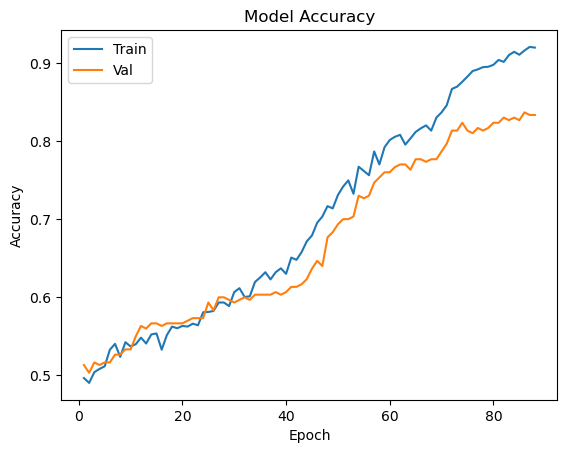

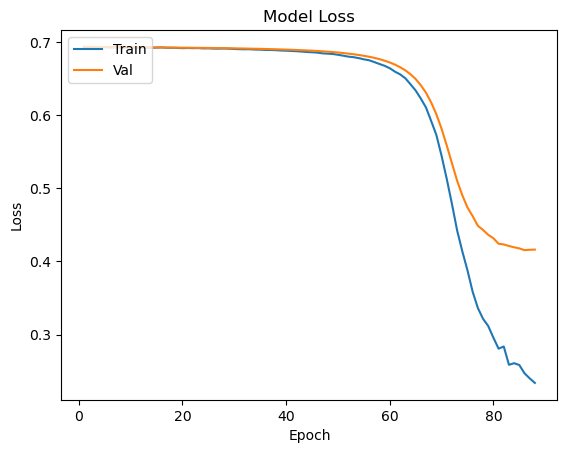

In [58]:
# Training graphs
plot_learningCurve(history, 88)

## D4. Predictive Accuracy

Below I've provided the code that runs the model on the test data. The output can be seen as well. The model achieves an accuracy of 0.81 on the test data, which means that it correctly predicted the sentiment of roughly 81% of the reviews in the test dataset. This is a pretty good accuracy, as anything above 70% is generally acceptable. However, let's get more in context. 

There are 133 negative reviews and 167 positive reviews in the test set. A baseline model that predicts every review to be positive would have an accuracy of 0.56 or roughly 56%. Because our actual model gained 25 percentage points in accuracy which is a *significant* improvement over this simple baseline model, we can say that this accuracy is indeed very good.

We can also check a confusion matrix to understand how accurate the model was on the test set. The confusion matrix below shows that the model only predicted 20 of the 133 negative reviews incorrectly and only 36 of the positive reviews incorrectly. If we do a little math, about 15% of the negative reviews were incorrectly categorized as positive, and about 22% of the positive reviews were incorrectly categorized as negative. The model did a little bit worse on the positive reviews, but overall these numbers are very similar, so the model performed almost equally as well when predicting truly negative reviews as it did for truly positive ones.

If you continue following the code below, you'll see I really went down a rabbit hole. I actually retrieved the original text and lemmatized text of all the incorrectly predicted reviews and tried to see if I could find any rhyme or reason the model might've gotten confused. I suspected perhaps lemmatization...or the removal of certain stopwords could have impacted the model. Understanding if these two things were a factor could help me improve the model in the future. Besides a couple of misspellings (like "devine" instead of "divine,") and really infrequently used words (like "abstruse,") I didn't really find a whole lot of rhyme or reason in the incorrectly predicted reviews.

The histograms showing the distribution of the incorrectly categorized reviews don't seem to skew one way or another, at least not in an extreme manner, as I had hoped. If the graph of negative reviews predicted to be positive, for example, had all the bars bunched up at the lower end of probabilities, then I might be able to say, "Well, the model incorrectly predicted these reviews, but at least it wasn't *sure* about it!" Likewise, in the graph of positive reviews predicted to be negative, if the bars were bunched up at the higher end of probabilities, I could've said something similar. Unfortunately, that is not what I found.

In [59]:
evaluation = model.evaluate(X_test_np, y_test_np, verbose = 0)
print("Test Loss: ", evaluation[0])
print("Test Accuracy: ", evaluation[1])

Test Loss:  0.41466858983039856
Test Accuracy:  0.8133333325386047


10/10 [==============================] - 0s 7ms/step


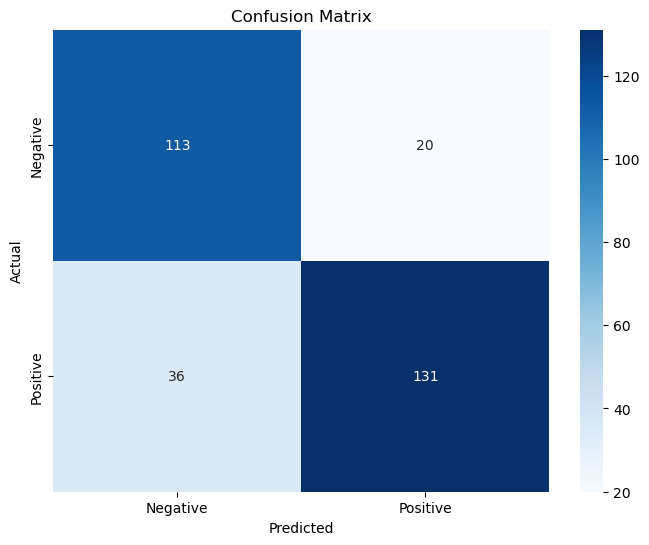

In [61]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

pred_probs = model.predict(X_test_np)
preds = (pred_probs > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test_np, preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [62]:
# Curious which reviews got mislabeled. Maybe we can guess why to improve future models?
results_df = pd.DataFrame({
    'Prob': pred_probs.flatten(),
    'Predicted': preds.flatten(),
    'True': y_test_np
})

results_df['Padded'] = df_all['padded'].iloc[X_test.index].values
results_df['Original Review'] = df_all['review'].iloc[X_test.index].values
results_df['Lemmatized Review'] = df_all['lemmatized'].iloc[X_test.index].values
results_df['Df_all Index'] = df_all.index[X_test.index]

mislabeled = results_df[results_df['Predicted'] != results_df['True']]

mislabeled['Predicted'] = mislabeled['Predicted'].replace({1: 'Positive', 0: 'Negative'})
mislabeled['True'] = mislabeled['True'].replace({1: 'Positive', 0: 'Negative'})

mislabeled[['Df_all Index', 'Original Review', 'Lemmatized Review','Prob', 'Predicted', 'True']]

,Df_all Index,Original Review,Lemmatized Review,Prob,Predicted,True
1,2769,both the hot sour the egg flower soups were absolutely 5 stars,hot sour egg flower soup absolutely 5 star,0.383629,Negative,Positive
6,1081,this if the first movie ive given a 10 to in years,first movie ive give 10 year,0.356052,Negative,Positive
11,833,my father has the v265 and the battery is dying,father v265 battery die,0.856020,Positive,Negative
12,1305,the story which was told so eloquently by francis ford coppola 25 years earlier really unfolds gradually and leaves room for the characters to develop,story tell eloquently francis ford coppola 25 year earlier really unfold gradually leaf room character develop,0.331961,Negative,Positive
16,1487,lifetime does not air it enough so if anyone knows what store sells it let me know because this is a musthave,lifetime not air enough anyone know store sell let know musthave,0.038628,Negative,Positive
26,2176,the service here leaves a lot to be desired,service leaf lot desire,0.624080,Positive,Negative
28,2439,if youre not familiar check it out,youre not familiar check,0.065254,Negative,Positive
30,2806,i could eat their bruschetta all day it is devine,could eat bruschetta day devine,0.456735,Negative,Positive
48,51,good protection and does not make phone too bulky,good protection not make phone bulky,0.193427,Negative,Positive
54,1890,the only consistent thread holding the series together were the amazing performances of leni parker and anita laselva as the two taelons in quiet idealogical conflict,consistent thread hold series together amaze performance leni parker anita laselva two taelons quiet idealogical conflict,0.861985,Positive,Negative


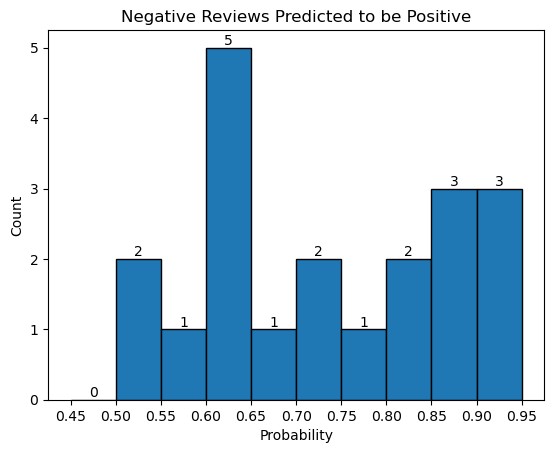

In [63]:
bins = np.arange(0.45, 1.0, 0.05)
counts, bins, patches = plt.hist(mislabeled[mislabeled['True'] == 'Negative']['Prob'], bins = bins, edgecolor='black')
plt.title('Negative Reviews Predicted to be Positive')
for count, x in zip(counts, bins):
    plt.text(x + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')
plt.xticks(bins)
plt.ylabel('Count')
plt.xlabel('Probability')
plt.show()

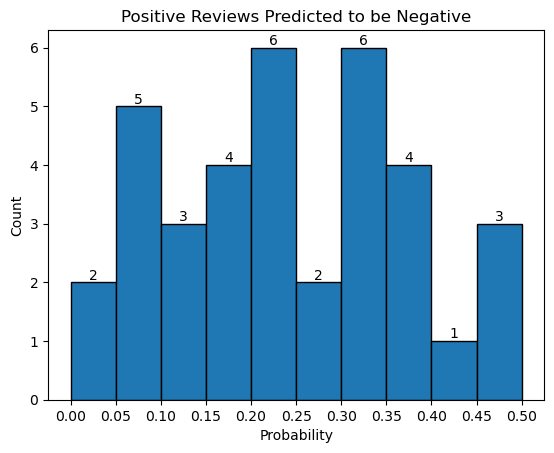

In [64]:
bins = np.arange(0.0, 0.55, 0.05)
counts, bins, patches = plt.hist(mislabeled[mislabeled['True'] == 'Positive']['Prob'], bins = bins, edgecolor='black')
plt.title('Positive Reviews Predicted to be Negative')
for count, x in zip(counts, bins):
    plt.text(x + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')
plt.xticks(bins)
plt.ylabel('Count')
plt.xlabel('Probability')
plt.show()

## E. Saved Model

Below is the code used to save the trained model.

In [65]:
model.save("D213_Task2_Model.h5")

## F. Functionality of Neural Network

The neural network performed very well compared to a baseline model for sentiment analysis of review data. I would have preferred the validation loss to be a little lower instead of plateauing a little at 0.4 so it fit a little better, but this is the best model I got after hours of experimentation with hyperparameters and layer types/sizes. The model performs almost equally well in predicting both classes. There is a little room for improvement in getting the model to fit a little better, but the model is pretty good overall.

I chose to use a network architecture that's a little more complicated than what might be expected. Plenty of sentiment analysis models use simple, unidirectional LSTM layers that do a good enough job of capturing patterns where previous words in a sequence are important to the meaning of a phrase as a whole. BiLSTM layers, with the capability of analyzing review data in both directions, are able to learn from the full context of the input data. For sentiment analysis, the ability to view the entire context is essential. BiLSTM layers also have a few drawbacks. They are more complex, take longer to train, and require more computational and memory resources. Because this dataset was so small, however, this was not a problem.

If I had used normal LSTM layers, only past context would have been considered in the model. I'll illustrate how this could be detrimental with an example. If a review's text is, "I thought the movie was boring at first, but the ending was absolutely fantastic," you can easily see that the model might immediately identify the first phrase as negative sentiment. Without the "future" context of the second phrase, a model might be unable to revise its initial recognition of heavily negative sentiment even when it gets to the final word, "fantastic." A BiLSTM reads from both directions and better understands the review as a whole.

Dropout layers were used in abundance to mitigate overfitting, which was egregious after running the model without these layers. Without them, the model would have severely overfit and the model would have had little predictive power. It is common practice to sandwich BiLSTM layers with dropout layers so that the model doesn't learn too much of the noise in the data and instead must rely on learning more robust and generalized patterns.

## G. Recommended Action

One of the major recommendations I have is to gather more data. I tried just about every overfitting mitigation technique in the book, and I still wasn't quite satisfied with the resulting model. The overfitting wasn't terrible in my final model, but it wasn't as perfect as I would like. A larger dataset for training might benefit the model, providing it more data from which to learn general patterns. With so little data, it may have been hard for the model to find enough examples of a pattern to learn it, so instead it learned more noise than it should have.

Another recommendation I have is that an analyst who has time may want to deal with typos in the data in some fashion before feeding it into the model. Because the dataset was so small, words with typos did not have a whole lot of representation and may have contributed to the model not performing quite as well as I'd have liked. There are packages that can auto-detect and fix typos, but they take several minutes to run even on a dataset of this size and may cause more harm than good. However, they are worth looking into. For the purpose of this paper, however, it was more trouble than it was worth.

My last recommendation would be to create this same model again, but use the appropriate vocabulary size during tokenization and when creating the embedding layer! Vocabulary size should be checked after the analyst is done removing words from the text data, not before. Using the vocabulary size prior to completing these steps leads to the analyst using a larger vocabulary size than necessary during tokenization and the creation of the embedding layer. This is something I mentioned earlier as a minor mistake I made while coding the model. With a dataset so small, it didn't really end up being a problem, but it is certainly not best practice and is a minor waste of resources. However, the impact was so minor it was not worth re-coding this model.

## H. Reporting

The ipynb file included is my presentation of this paper in an "industry-relevant interactive development environment." If you are reading this with the PDF file, you will find the ipynb attached.

## I. Code Sources

Dr. Sewell's Webinars

GeeksforGeeks. (2022, January 11). Python Regex: re.search() VS re.findall(). GeeksforGeeks. https://www.geeksforgeeks.org/python-regex-re-search-vs-re-findall/

GeeksforGeeks. (2023, June 8). Bidirectional LSTM in NLP. GeeksforGeeks. https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/#

## J. Content Sources

Ali, M. (2024, September 12). Introduction to Activation Functions in Neural Networks. DataCamp. Retrieved October 6, 2024, from https://www.datacamp.com/tutorial/introduction-to-activation-functions-in-neural-networks

Aravindpai. (2024, September 17). Analyzing types of neural networks in deep learning. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/02/cnn-vs-rnn-vs-mlp-analyzing-3-types-of-neural-networks-in-deep-learning/

Baheti, P. (2024, July 2). Train Test Validation Split: How To & Best Practices [2024]. V7. https://www.v7labs.com/blog/train-validation-test-set

Coach, G. B.-. D. S. (2023, August 17). Do you know overfitting and underfitting? - Gerzson Boros - The Data Science Coach - Medium. Medium. https://medium.com/@datascienceeurope/do-you-know-overfitting-and-underfitting-f27f87ac2f37

GeeksforGeeks. (2023, June 8). Bidirectional LSTM in NLP. GeeksforGeeks. https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/#

GeeksforGeeks. (2024, May 27). Binary Cross Entropy/Log loss for binary classification. GeeksforGeeks. https://www.geeksforgeeks.org/binary-cross-entropy-log-loss-for-binary-classification/#

GeeksforGeeks. (2024a, February 16). Early stopping on validation loss or on accuracy? GeeksforGeeks. https://www.geeksforgeeks.org/early-stopping-on-validation-loss-or-on-accuracy/

Gorale, C. (2024, June 25). Applying lowercase before and after tokenization in NLP. Medium. https://cgorale111.medium.com/applying-lowercase-before-and-after-tokenization-in-nlp-67f50462b06f

Kumari, P. (2023, June 23). Embedded Layer - Priyanka Kumari - Medium. Medium. https://medium.com/@kumari01priyanka/embedded-layer-12cccb9a5def

Mishra, M. (2023, May 28). The learning rate: a hyperparameter that matters - Mohit Mishra - medium. Medium. https://mohitmishra786687.medium.com/the-learning-rate-a-hyperparameter-that-matters-b2f3b68324ab

Mishra, P. (2024, October 3). Understanding and implementing LSTM networks - Palash Mishra - medium. Medium. https://medium.com/@palashm0002/understanding-and-implementing-lstm-networks-41ca52495108

Saxena, S. (2024, October 1). What is LSTM? Introduction to Long Short-Term Memory. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/

Wei, D. (2024, January 30). Demystifying the Adam Optimizer in machine learning. Medium. https://medium.com/@weidagang/demystifying-the-adam-optimizer-in-machine-learning-4401d162cb9e

Yadav, H. (2023, May 31). Dropout in neural networks - towards data science. Medium. https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9